<a href="https://colab.research.google.com/github/hukim1112/MLDL/blob/master/lecture8/MIT_indoor_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT indoor classification 데이터셋

## 분류할 데이터셋 다운로드

gdown의 rate-limit로 인해 24시간 내 많은 횟수로 다운로드를 시도할 경우 permission denied가 발생하는 문제가 있습니다. 
https://drive.google.com/file/d/1kUY5d23MTPbf5P1bi4eSss7_yntYJrWt/view

그 경우 위 링크의 구글 드라이브에 직접 접근해 학습데이터를 다운하신 뒤, 본인의 드라이브에 업로드 후 마운트해서 사용하시기 바랍니다. 마운트 방법은 아래 참고를 확인해주세요.

참고 : https://ikaros79.tistory.com/entry/03-Google-Colaboraty-%ED%99%9C%EC%9A%A9%ED%95%98%EA%B8%B0


In [ ]:
#(1-1) download : colab으로 다이렉트 다운로드
!gdown --id 1kUY5d23MTPbf5P1bi4eSss7_yntYJrWt 

In [8]:
#(1-2)mount : 데이터를 다운한 뒤 구글드라이브에서 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
#(2)
#파일을 코랩에 업로드해서 사용하는 경우
!unzip -qq "/content/train_imgs.zip" #unzip

#구글드라이브에 업로된 파일을 마운트해서 사용하는 경우. zip 파일의 드라이브 내 경로(마우스 우클릭 후 경로복사)를 사용.
!unzip -qq "/content/gdrive/MyDrive/4.teaching/3.롯데정보통신/데이터/MIT indoor scenes/train_imgs.zip" #unzip 예시. 저장한 경로에 맞게 변경 필요.

## 라이브러리 import

In [10]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from matplotlib import pyplot as plt

## 파일경로로 사진에 접근하기

In [11]:
import pathlib

data_dir = "/content/train_imgs"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count) #총 학습데이터 수

14274


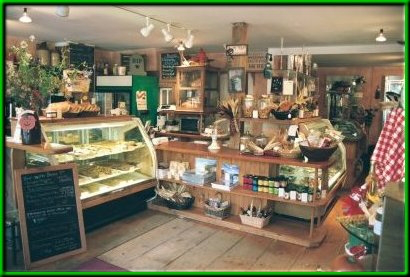

In [12]:

roses = list(data_dir.glob('bakery/*'))
PIL.Image.open(str(roses[0]))

## ***필독! 영상 중 decoding 오류 영상을 제거합니다***

전체 데이터 중 소수의 bmp로 인코딩된 영상 파일 존재


- 예외처리로 tf.image.decode_bmp로 디코딩
- 파일 제거 (권장)

In [ ]:
# 5개 파일을 제거합니다.
!rm "/content/train_imgs/laundromat/Laundry_Room_bmp.jpg"
!rm '/content/train_imgs/auditorium/auditorium986_120.jpg'
!rm '/content/train_imgs/kindergarden/classroom_north_bmp.jpg'
!rm '/content/train_imgs/auditorium/auditorium776_118.jpg'
!rm '/content/train_imgs/waitingroom/Bistro_3_BMP.jpg'

## 파일 경로로 텐서플로우 데이터셋 오브젝트 생성

보다 세밀한 제어를 위해 `tf.data`을 사용하여 자체 입력 파이프라인을 작성할수 있습니다. 이 섹션에서는 이전에 다운로드한 zip 파일 경로부터 시작하여 이를 수행하는 방법을 보여줍니다.

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

#data_dir의 하위 폴더 및 파일은 다음과 같습니다.
print(os.listdir(data_dir))
#파일의 트리 구조를 사용하여 `class_names` 목록을 리스트로 만들 수 있습니다.
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

데이터세트를 훈련 및 검증으로 분할합니다.

In [ ]:
val_size = int(image_count * 0.2)

val_ds = list_ds.take(val_size) #val size만큼 취하고,
train_ds = list_ds.skip(val_size) #나머지를 train dataset으로..

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

파일 경로를 `(img, label)` 쌍으로 변환하는 간단한 함수를 작성합니다.

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

img_height = 224
img_width = 224

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
def augment(img, label):
    img = tf.image.resize_with_crop_or_pad(img, img_height + 8, img_width + 8) 
    # Random crop back to the original size
    img = tf.image.random_crop(img, size=[img_height, img_width, 3])
    img = tf.image.random_brightness(img, 0.15)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, 0.5)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    return img, label

In [ ]:
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

## 성능을 위한 데이터세트 구성하기

이 데이터세트로 모델을 훈련하려면 데이터에 대해 다음이 필요합니다.

- 잘 섞는다.
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.

이러한 기능은 `tf.data` API를 사용하여 추가할 수 있습니다. 자세한 내용은 [입력 파이프라인 성능](../../guide/performance/datasets) 가이드를 참조하세요.

In [ ]:
batch_size = 32
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## 데이터 시각화하기

이 데이터세트를 이전에 작성한 데이터세트와 유사하게 시각화할 수 있습니다.

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

전체 데이터셋 루프의 shape 확인

In [ ]:
for imgs, labels in train_ds:
  print(imgs.shape)